# US CO2 DATA

In [1]:
# imports
import pandas as pd
import numpy as np
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('annual-co2-emissions-per-country.csv')

In [3]:
df.head()

,Entity,Code,Year,Annual CO2 emissions
0,Afghanistan,AFG,1949,14656
1,Afghanistan,AFG,1950,84272
2,Afghanistan,AFG,1951,91600
3,Afghanistan,AFG,1952,91600
4,Afghanistan,AFG,1953,106256


In [4]:
df.rename(columns={'Entity':'country', 'Code':'code', 'Year':'year', 'Annual CO2 emissions': 'co2'}, inplace=True)

In [5]:
df = df[df['country'] == "United States"]

In [6]:
df.head()

,country,code,year,co2
22088,United States,USA,1800,252816
22089,United States,USA,1801,267472
22090,United States,USA,1802,289456
22091,United States,USA,1803,296784
22092,United States,USA,1804,333424


In [7]:
df.tail()

,country,code,year,co2
22303,United States,USA,2015,5412432194
22304,United States,USA,2016,5292267561
22305,United States,USA,2017,5253606130
22306,United States,USA,2018,5424881502
22307,United States,USA,2019,5284696657


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 22088 to 22307
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  220 non-null    object
 1   code     220 non-null    object
 2   year     220 non-null    int64 
 3   co2      220 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 8.6+ KB


In [9]:
# df.co2 = df.co2.astype(float)

In [10]:
#df['year'] = df.year
#df['month'] = df.month
#df['day'] = df.month
#df['weekday'] = df.day_name()
#df.head()

In [11]:
df.year = pd.to_datetime(df.year, format='%Y')


In [12]:
df = df.set_index('year').sort_index()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 1800-01-01 to 2019-01-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  220 non-null    object
 1   code     220 non-null    object
 2   co2      220 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 6.9+ KB


In [14]:
df.head()

,country,code,co2
year,,,
1800-01-01,United States,USA,252816
1801-01-01,United States,USA,267472
1802-01-01,United States,USA,289456
1803-01-01,United States,USA,296784
1804-01-01,United States,USA,333424


In [15]:
df.tail()

,country,code,co2
year,,,
2015-01-01,United States,USA,5412432194
2016-01-01,United States,USA,5292267561
2017-01-01,United States,USA,5253606130
2018-01-01,United States,USA,5424881502
2019-01-01,United States,USA,5284696657


In [16]:
df.isna().sum()

country    0
code       0
co2        0
dtype: int64

In [17]:
df = df.drop(['code', 'country'], axis = 1)

In [18]:
df.head()

,co2
year,
1800-01-01,252816
1801-01-01,267472
1802-01-01,289456
1803-01-01,296784
1804-01-01,333424


In [19]:
df.isna().sum()

co2    0
dtype: int64

In [20]:
# checking the size of the data using len() function
df_size = len(df)
df_size

220

In [21]:
# looking a half of the data .5
len(df) * .5

110.0

In [22]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

In [23]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [24]:
# sum of train, validate and test = total number of rows? 
print(len(train) + len(validate) + len(test) == len(df))

True


In [25]:
# test the row starts
print(df.head(1) == train.head(1))

             co2
year            
1800-01-01  True


In [26]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,co2
year,
1975-01-01,4400795008
1976-01-01,4607168187


In [27]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

,co2
year,
2019-01-01,5284696657
2019-01-01,5284696657


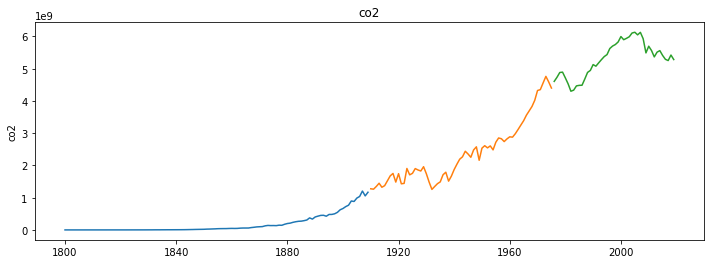

In [28]:
# plot the data points, color by train, validate, test
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [29]:

# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values and compute the 
    mean squared error and then take the square root and round to zero decimals
    it will return the rmse 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [30]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    
    plt.show()

In [31]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [32]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [33]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the mode_type as a string, the target variable as a string
    and rund the evaluate() function to compute the rmse,
    and append the dataframe a row with the model_type, target_var, and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [34]:
# last observed value
# make predictions
# taking the last observation
last_co2 = train['co2'][-1:][0]
last_co2

1169267069

In [35]:
# make predictions
yhat_df = pd.DataFrame({'co2': [last_co2]}, 
                       index = validate.index)

yhat_df.head(2)

,co2
year,
1910-01-01,1169267069
1911-01-01,1169267069


co2 -- RMSE: 845042215


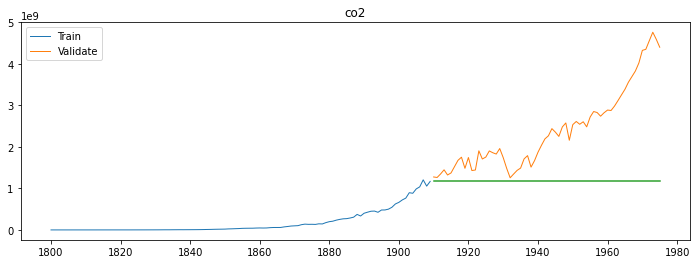

In [36]:
for col in train.columns:
    plot_and_eval(col)

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [38]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,845042215.0


In [39]:
# Simple Average
# make predictions
avg_co2 = round(train['co2'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'co2': [avg_co2]}, 
                       index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [40]:
yhat_df.head() # check_yo_head

,co2
year,
1910-01-01,1.762969e+08
1911-01-01,1.762969e+08
1912-01-01,1.762969e+08
1913-01-01,1.762969e+08
1914-01-01,1.762969e+08


co2 -- RMSE: 2406707148


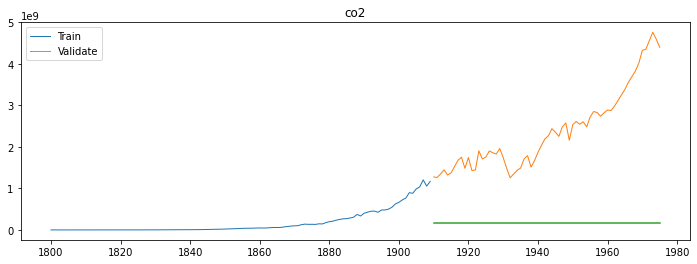

In [41]:
# plotting actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [42]:
# evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [43]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,8.450422e+08
1,simple_average,co2,2.406707e+09


In [44]:

# compute a 30 day rolling average,
# use the most recent/last 30 day period value to predict forward.
period = 30

avg_co2 = round(train['co2'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,co2
year,
1910-01-01,5.641285e+08
1911-01-01,5.641285e+08
1912-01-01,5.641285e+08


co2 -- RMSE: 2056484653


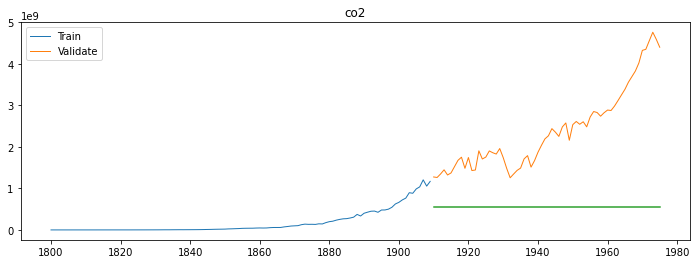

In [45]:
# plotting actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [46]:

# evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

In [47]:

# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,8.450422e+08
1,simple_average,co2,2.406707e+09
2,30d moving average,co2,2.056485e+09


In [48]:
# Let's try out several other values for periods

periods = [1, 5, 10, 15, 20, 25, 30]

for p in periods:
    avg_co2 = round(train['co2'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'co2'
                            )

In [49]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,8.450422e+08
1,simple_average,co2,2.406707e+09
2,30d moving average,co2,2.056485e+09
3,1d moving average,co2,1.546310e+09
4,5d moving average,co2,1.608249e+09
5,10d moving average,co2,1.733174e+09
6,15d moving average,co2,1.849526e+09
7,20d moving average,co2,1.929283e+09
8,25d moving average,co2,1.998096e+09
9,30d moving average,co2,2.056485e+09


In [50]:

# Which is best so far?
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [51]:

# evaluation metrics on eval_df
eval_df[((eval_df.rmse == min_rmse_amount)
        )]

,model_type,target_var,rmse
0,last_observed_value,co2,845042215.0


In [52]:

# setting up for plots
plt.rc('figure', figsize=(12, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

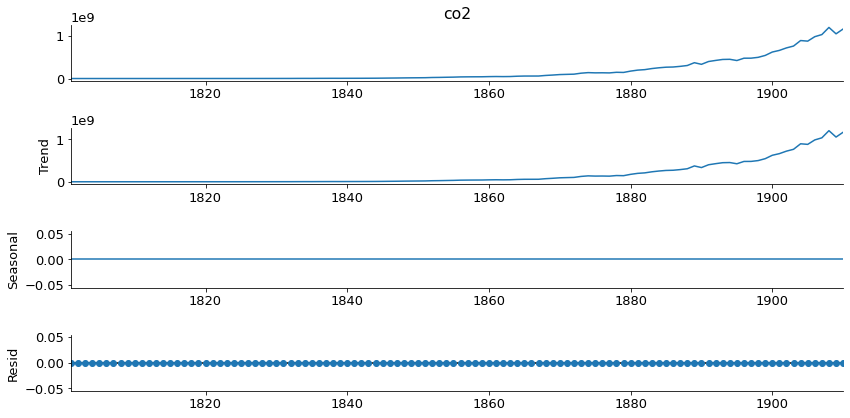

In [53]:
# Holt's Linear Trend
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train['co2'].resample('Y').mean()).plot()
plt.show()

In [54]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

co2 -- RMSE: 410284536


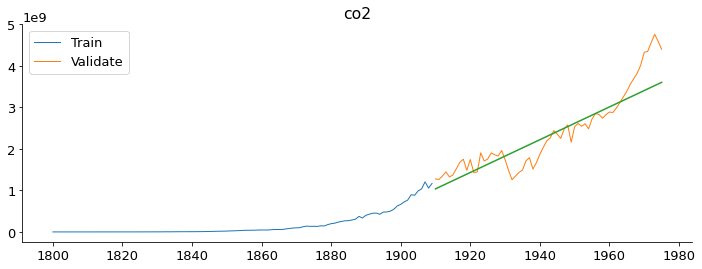

In [55]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [56]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [57]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,co2,8.450422e+08
1,simple_average,co2,2.406707e+09
2,30d moving average,co2,2.056485e+09
3,1d moving average,co2,1.546310e+09
4,5d moving average,co2,1.608249e+09
5,10d moving average,co2,1.733174e+09
6,15d moving average,co2,1.849526e+09
7,20d moving average,co2,1.929283e+09
8,25d moving average,co2,1.998096e+09
9,30d moving average,co2,2.056485e+09


In [58]:
#df = pd.read_csv('annual-co2-emissions-per-country.csv')

In [59]:
#df.rename(columns={'Entity':'country', 'Code':'code', 'Year':'year', 'Annual CO2 emissions': 'co2'}, inplace=True)
#df = df[df['country'] == "United States"]
#df = df.drop(['code', 'country'], axis = 1)

In [60]:
df.head()

,co2
year,
1800-01-01,252816
1801-01-01,267472
1802-01-01,289456
1803-01-01,296784
1804-01-01,333424


In [61]:
df.isna().sum()

co2    0
dtype: int64

In [62]:
# Predict Based on Previous Cycle

# re-split the data
train = df[:'2017']
validate = df[('2018')]
test = df[('2019')]

In [63]:
print(train.shape)
print(validate.shape)
print(test.shape)

(218, 1)
(1, 1)
(1, 1)


In [64]:
yhat_df = train['2017'] + train.diff(30).mean()

In [65]:
pd.concat([yhat_df.head(1), validate.head(1)])

,co2
year,
2017-01-01,6.144843e+09
2018-01-01,5.424882e+09


In [66]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

1

In [67]:
yhat_df

,co2
year,
2018-01-01,6.144843e+09


co2 -- RMSE: 719961775


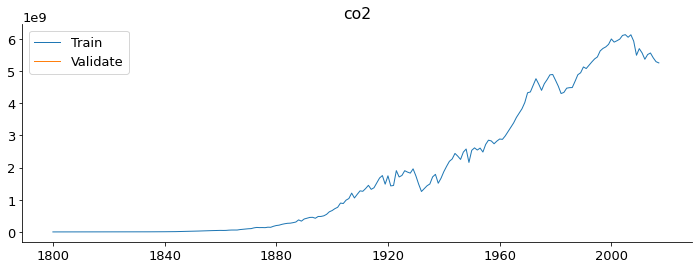

In [68]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [69]:
# get the min rmse for each variable

min_rmse_co2 = eval_df.groupby('target_var')['rmse'].min()[0]


# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_co2)
        )]

,model_type,target_var,rmse
10,Holts,co2,410284536.0


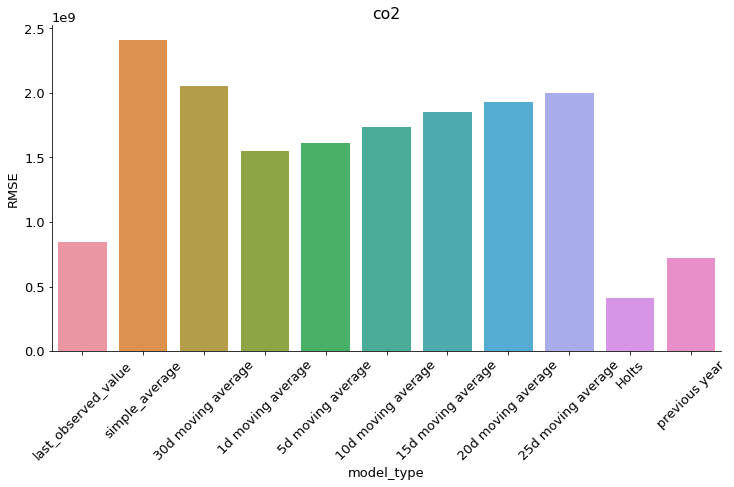

In [70]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [71]:
yhat_df = validate + train.diff(30).mean()
yhat_df.index = test.index

In [72]:
rmse_co2 = round(sqrt(mean_squared_error(test['co2'], yhat_df['co2'])), 0)

In [ ]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

In [ ]:
print("rmse - co2: ", rmse_co2)

for col in train.columns:
    plot_and_eval(col)

In [ ]:
my_color = 'red'
sentence = (f'I love {my_color} so much!')
love_red = (sentence * 2)
print(love_red)